In [1]:
from Libs.load_data import DataLoader, get_dataset_split
from Libs.config import models_data_folder
from Libs.models import make_cnn, make_lstm

import os
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, auc, roc_curve

2023-03-24 07:33:47.861476: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data_loader = DataLoader(run=100, N=1000, s=0.5, t=0.01, d=0.2, m=1, override=False, folder=models_data_folder)
params = data_loader.get_params()
params

{'run': 100,
 'sigma': [0.5],
 'theta': [0.01],
 'mu': [1],
 'delta': [0.2],
 'N': 1000}

In [3]:
Xs, best_labels = data_loader.get_grid()

In [4]:
dataset_split_params = {
    'window_size': 20, # how large is the window
    'overlap_size': None, # how many time interval of overlap there is between the windows
    'label_treshold': 1, # how many labels have to be at 1 in the window_size to consider the current window as a flare
    'split_on_run': True, # if True the windows of a run cannot be on different sets
    'shuffle_run': False, # if True shuffles the order of the runs before computing the windows
    'shuffle_window': False, # if True shuffles the order of the windows in the resulting dataframes
    'test_size': 0.3, # size of the test set expressed in percentage
    'val_size': 0.2, # size of the validation set expressed in percentage, considered only if get_validation is True
    'get_validation': True, # if True the output would be train,val,test set, otherwise it would be train,test
    'random_state': 42 # sets the seed for reproducibility
}

In [5]:
results = {}

models_folder = "models"
for overlap_size in np.sort([int(name.split('_')[1]) for name in os.listdir(models_folder)]):
    dataset_split_params['overlap_size'] = overlap_size
    df_train, df_val, df_test = get_dataset_split(Xs, best_labels, **dataset_split_params)

    X_train, y_train = df_train.iloc[:,:-1].to_numpy(), df_train.future_flare.to_numpy()
    X_val, y_val = df_val.iloc[:,:-1].to_numpy(), df_val.future_flare.to_numpy()
    X_test, y_test = df_test.iloc[:,:-1].to_numpy(), df_test.future_flare.to_numpy()

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_std = scaler.transform(X_train)
    X_val_std = scaler.transform(X_val)
    X_test_std = scaler.transform(X_test)
    # Make the data uniform to multivariate timeseries
    X_train_cnn = X_train_std.reshape((X_train_std.shape[0], X_train_std.shape[1], 1))
    X_val_cnn = X_val_std.reshape((X_val_std.shape[0], X_val_std.shape[1], 1))
    X_test_cnn = X_test_std.reshape((X_test_std.shape[0], X_test_std.shape[1], 1))
    
    results[overlap_size] = {}
    
    overlap_folder = os.path.join(models_folder, f'overlap_{overlap_size}')
    for m in os.listdir(overlap_folder):
        filename, extension = m.split('.')
        if extension != 'pickle':
            if extension == 'pkl':
                model_type = filename.split('_')[-1]
                clf = joblib.load(os.path.join(overlap_folder, m))
                y_pred = clf.predict(X_test)
            if extension == 'h5':
                model_type = filename.split('_')[0].lower()
                if  model_type == 'cnn':
                    model = make_cnn(input_shape=X_train_cnn.shape[1:], num_classes=2)
                if model_type == 'lstm':
                    model = make_lstm((X_train_std.shape[1], 1))
                model.load_weights(os.path.join(overlap_folder, m))
                if model_type == 'cnn':
                    y_pred = np.round(model.predict(X_test_cnn), 0)
                if model_type == 'lstm':
                    y_pred = np.round(model.predict(X_test_std), 0)
            fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=1)
            results[overlap_size][model_type] = {}
            results[overlap_size][model_type]['f1_macro'] = f1_score(y_test, y_pred, average='macro')
            results[overlap_size][model_type]['auc'] = auc(fpr, tpr)
                
results

901/901 [==============================] - 4s 4ms/step


{0: {'cnn': {'f1_macro': 0.8654513888888888, 'auc': 0.8211883872035758},
  'dt': {'f1_macro': 0.8865640709057236, 'auc': 0.863065430617059},
  'knn': {'f1_macro': 0.8673563245156484, 'auc': 0.8272824152630055},
  'lp': {'f1_macro': 0.8117277501027982, 'auc': 0.7427730414269751},
  'nb': {'f1_macro': 0.8597675373531555, 'auc': 0.8368269668501428},
  'svc': {'f1_macro': 0.8600487634970393, 'auc': 0.9019989239746721},
  'lstm': {'f1_macro': 0.8600502676589634, 'auc': 0.8425433514050407}},
 5: {'cnn': {'f1_macro': 0.8820804536858246, 'auc': 0.8307857142857143},
  'dt': {'f1_macro': 0.890576041688784, 'auc': 0.8681428571428571},
  'knn': {'f1_macro': 0.8923532139466073, 'auc': 0.856},
  'lp': {'f1_macro': 0.8573426573426572, 'auc': 0.7985714285714286},
  'nb': {'f1_macro': 0.8677385203818331, 'auc': 0.8563571428571428},
  'svc': {'f1_macro': 0.872433724016755, 'auc': 0.9030714285714286},
  'lstm': {'f1_macro': 0.8888315415891654, 'auc': 0.8656428571428573}},
 10: {'cnn': {'f1_macro': 0.8694

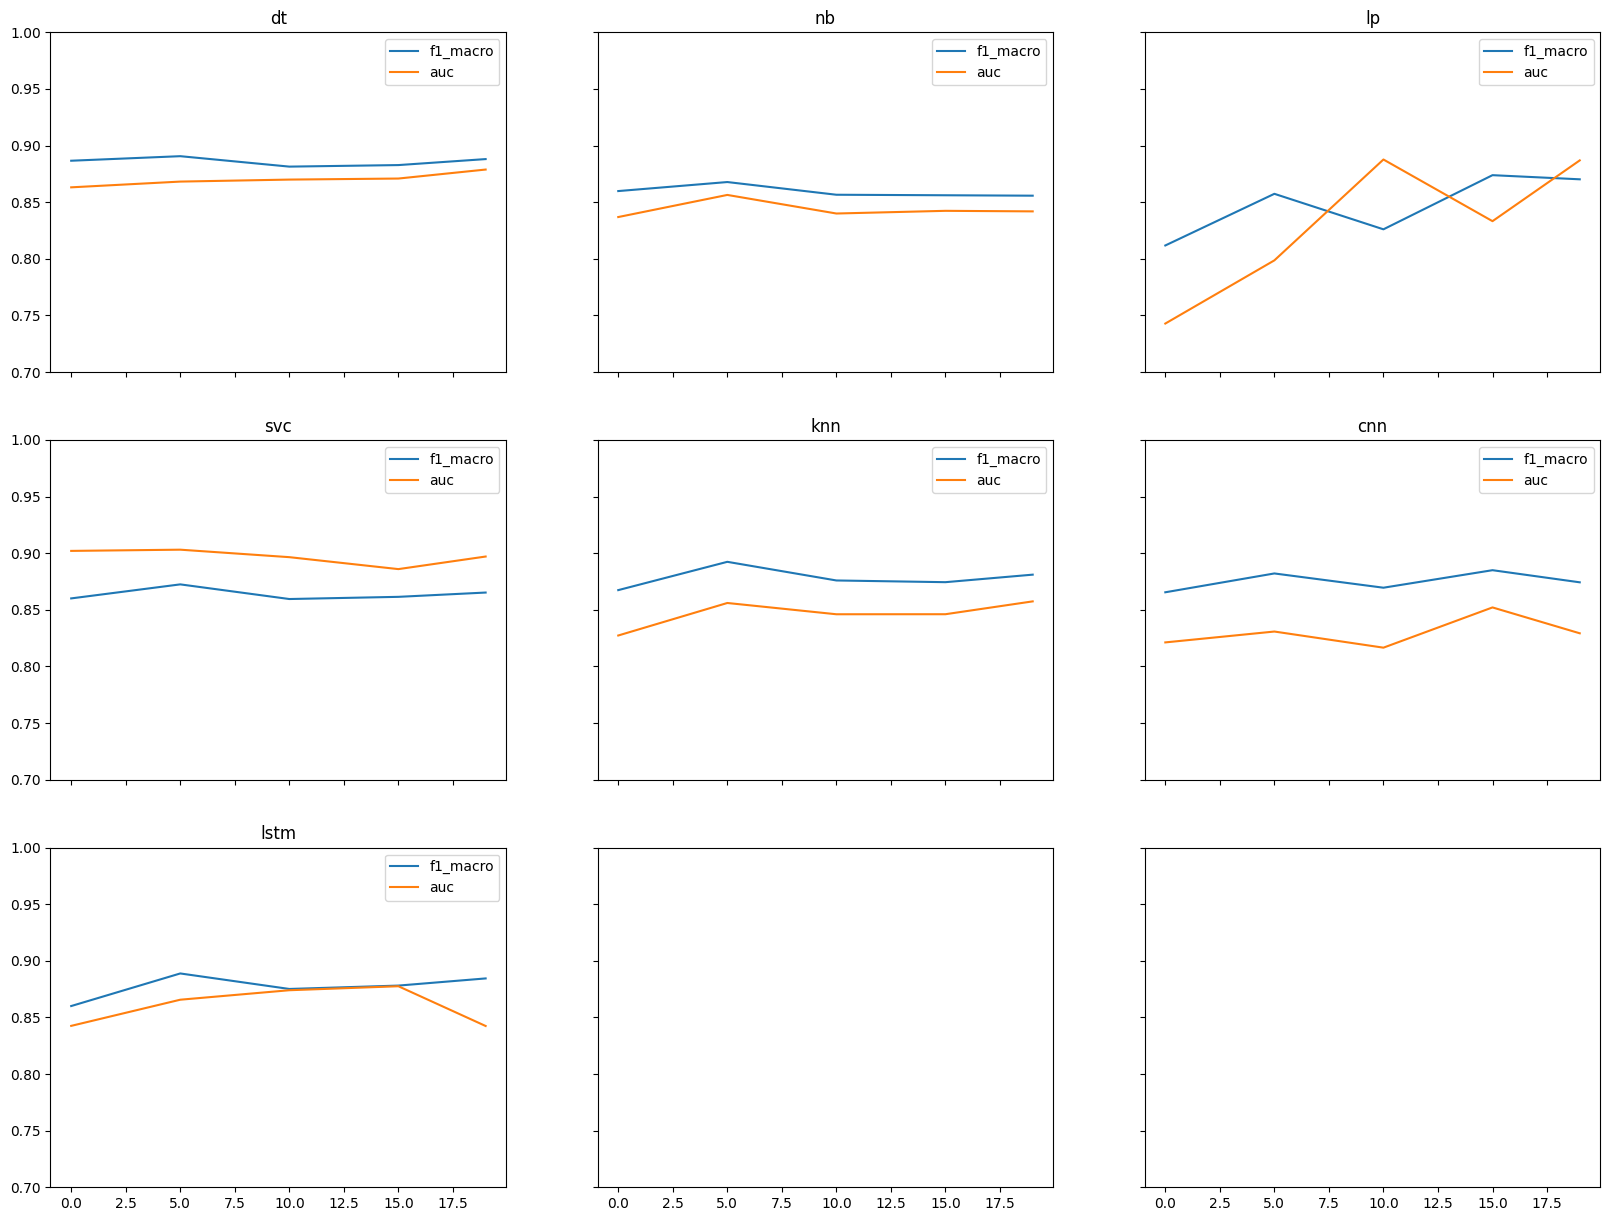

In [6]:
plt.rcParams["figure.figsize"] = (20,15)
model_lbls = ['dt', 'nb', 'lp', 'svc', 'knn', 'cnn', 'lstm']
x_axis = [0, 5, 10, 15, 19]
fig, axs = plt.subplots(3, 3, sharex='all', sharey='all')
plt.setp(axs, ylim=(0.7, 1))
for idx in range(len(model_lbls)):
    i = idx // 3
    j = idx % 3
    axs[i, j].plot(x_axis, [results[x][model_lbls[idx]]['f1_macro'] for x in x_axis], label='f1_macro')
    axs[i, j].plot(x_axis, [results[x][model_lbls[idx]]['auc'] for x in x_axis], label='auc')
    axs[i, j].legend()
    axs[i, j].title.set_text(model_lbls[idx])
plt.show()

# Bibliography
\[1\] _On the distribution of fluxes of gamma-ray blazars: hints for a stochastic process?_, Tavecchio et al., [https://arxiv.org/pdf/2004.09149.pdf](https://arxiv.org/pdf/2004.09149.pdf)
<!-- cite with: [\[1\]](https://arxiv.org/pdf/2004.09149.pdf)  -->
\[2\] _Time Series Classification from Scratch with Deep Neural Networks: A Strong Baseline_, Wang et al., [https://arxiv.org/abs/1611.06455](https://arxiv.org/abs/1611.06455)
<!-- cite with: [\[2\]](https://arxiv.org/abs/1611.06455)  -->
\[3\] _Solar Flare Prediction Based on the Fusion of Multiple Deep-learning Models_, Tang et al., [https://iopscience.iop.org/article/10.3847/1538-4365/ac249e/meta](https://iopscience.iop.org/article/10.3847/1538-4365/ac249e/meta)
<!-- cite with: [\[3\]](https://iopscience.iop.org/article/10.3847/1538-4365/ac249e/meta)  -->
\[4\] _Predicting Solar Energetic Particles Using SDO/HMI Vector Magnetic Data Products and a Bidirectional LSTM Network_, Abduallah et al., [https://iopscience.iop.org/article/10.3847/1538-4365/ac5f56/meta](https://iopscience.iop.org/article/10.3847/1538-4365/ac5f56/meta)
<!-- cite with: [\[4\]](https://iopscience.iop.org/article/10.3847/1538-4365/ac5f56/meta) -->